<a href="https://colab.research.google.com/github/turbocradozaure/python-class/blob/S5/Copie_de_SQL_Alchemy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Python Programming for Business Analytics - Basics of Python - SQL Alchemy

## What is SQLAlchemy?

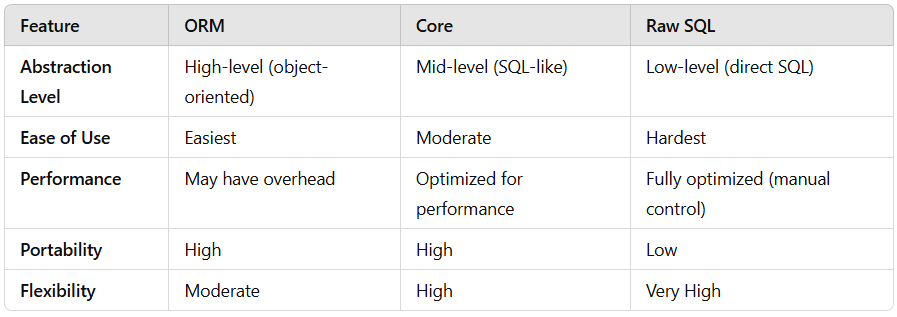

## Why Use SQLAlchemy

- Flexibility: Combines the power of raw SQL with Pythonic abstractions.

- Database Agnosticism: Supports various databases like SQLite, PostgreSQL, MySQL, and more.

- Performance: Efficiently manages database connections and queries.

- Extensibility: Integrates seamlessly with other libraries and frameworks.

## Setup and Configuration

In [ ]:
!pip install sqlalchemy --quiet

In [ ]:
# current working directory
import os
os.getcwd()

## SQLAlchemy ORM (Object Relational Mapper)

In [ ]:
# Here’s an example of connecting to an SQLite database in a Jupyter Notebook environment
from sqlalchemy import create_engine

# Define the database path
# This creates or connects to a file-based SQLite database in the current working directory.
db_path = os.path.join(os.getcwd(), "example.db")
db_url = f"sqlite:///{db_path}"

# Create an SQLite engine
# The `echo=True` option outputs all the SQL queries executed to help with debugging.
engine = create_engine(db_url, echo=True)

In [ ]:
# Define a table using SQLAlchemy’s Table and Column objects:
from sqlalchemy import Table, Column, Integer, String, MetaData

# Define metadata to hold table definitions.
metadata = MetaData()

# Define the 'users' table with its columns and data types.
users = Table(
    "users", metadata,
    Column("id", Integer, primary_key=True),  # Primary key column.
    Column("name", String),  # Name column to store text values.
    Column("age", Integer)  # Age column to store integer values.
)

# Create the table in the database.
metadata.create_all(engine)  # Ensures all tables in metadata are created.

In [ ]:
# Displaying Query Results in Pandas
import pandas as pd
from sqlalchemy import select

# Query data and convert to a DataFrame
stmt = select(users)  # Select all data from the 'users' table.
with engine.connect() as conn:
    results = conn.execute(stmt)
    # Convert results to a Pandas DataFrame for easy analysis.
    df = pd.DataFrame(results.fetchall(), columns=results.keys())

# Display the DataFrame
df.head()

## Transactions

- with engine.begin():

Easiest for Core style.
You get a conn object with an active transaction automatically committed or rolled back when the block ends.

- with conn.begin():

For fine-grained control if you already have a connection.
Opens/commits/rolls back automatically around that block.

- Manual trans = conn.begin()

Old-school explicit control. You must remember to commit() or rollback().

- with Session(engine) as session: with session.begin(): (ORM)

Best practice for ORM.
Automatically commits/rolls back at block exit.
Manual Session (ORM)

session.begin(), then session.commit() or session.rollback() yourself.

### Performing CRUD Operations

**conn.begin()**

Commitis done automatically after insert execution.

In [ ]:
# insert statement
from sqlalchemy import insert

# Insert a single record into the 'users' table.
stmt = insert(users).values(name="Alice", age=30)  # Define the insert statement with values.
with engine.connect() as conn:
    with conn.begin():         # Start a transaction explicitly
        conn.execute(stmt)       # Execute the INSERT


In [ ]:
stmt = select(users)  # Select all data from the 'users' table.
with engine.connect() as conn:
    results = conn.execute(stmt)
    # Convert results to a Pandas DataFrame for easy analysis.
    df = pd.DataFrame(results.fetchall(), columns=results.keys())

# Display the DataFrame
df.head()

**Manual transaction**

We start and control transaction untill commit or rollback.

In [ ]:
# Insert multiple records
stmt = insert(users).values([
    {"name": "Bob", "age": 25},  # First record.
    {"name": "Charlie", "age": 35}  # Second record.
])
with engine.connect() as conn:
    trans = conn.begin()         # Start a transaction explicitly
    try:
        conn.execute(stmt)       # Execute the INSERT
        trans.commit()           # Commit if no errors occur
    except:
        trans.rollback()         # Roll back if an exception occurs
        raise

**READ**

Explanation:

- select(users) generates a SELECT * FROM users statement.
- results.fetchall() retrieves all rows.
- We wrap it in a pandas.DataFrame for a quick tabular view.

In [ ]:
# Select all columns from 'users'
stmt = select(users)
with engine.connect() as conn:
    results = conn.execute(stmt)
    df = pd.DataFrame(results.fetchall(), columns=results.keys())

df.head()

**UPDATE**

Explanation:

- update(users) targets the users table.
- .where(users.c.name == "Alice") selects rows where the name is "Alice".
- .values(age=31) sets the age column to 31 for matched rows.

In [ ]:
# Update "Alice"'s age to 31
from sqlalchemy import update
stmt = (
    update(users)
    .where(users.c.name == "Alice")
    .values(age=31)
)
with engine.connect() as conn:
    trans = conn.begin()         # Start a transaction explicitly
    try:
        conn.execute(stmt)
        trans.commit()           # Commit if no errors occur
    except:
        trans.rollback()         # Roll back if an exception occurs
        raise

In [ ]:
stmt = select(users)
with engine.connect() as conn:
    results = conn.execute(stmt)
    df = pd.DataFrame(results.fetchall(), columns=results.keys())

df.head()

**DELETE**

Explanation:

- delete(users) creates a DELETE FROM users statement.
- .where(users.c.name == "Bob") specifies the condition to match.

In [ ]:
from sqlalchemy import delete

# Delete the record for "Bob"
stmt = delete(users).where(users.c.name == "Bob")
with engine.connect() as conn:
    with conn.begin():         # Start a transaction explicitly
        conn.execute(stmt)
        # The transaction is committed automatically here

In [ ]:
stmt = select(users)
with engine.connect() as conn:
    results = conn.execute(stmt)
    df = pd.DataFrame(results.fetchall(), columns=results.keys())

df.head()

**join**

In [ ]:
from sqlalchemy import (
    create_engine, Table, Column, Integer, String, ForeignKey, MetaData, select
)
import pandas as pd

engine = create_engine("sqlite:///:memory:")
metadata = MetaData()

# Define tables (no need for "if 'users' not in metadata.tables:")
users = Table(
    "users", metadata,
    Column("id", Integer, primary_key=True),
    Column("name", String)
)
orders = Table(
    "orders", metadata,
    Column("id", Integer, primary_key=True),
    Column("user_id", Integer, ForeignKey("users.id")),
    Column("amount", Integer)
)

# Create all tables
metadata.create_all(engine)

# ---------------------------------------------
# Everything in ONE transaction block:
# ---------------------------------------------
with engine.connect() as conn:
    with conn.begin():
        # 1) Check existing users
        existing_users = conn.execute(
            select(users.c.id).where(users.c.id.in_([1, 2]))
        ).fetchall()

        # 2) Insert if not found
        if not existing_users:
            conn.execute(
                users.insert().values([
                    {"id": 1, "name": "Alice"},
                    {"id": 2, "name": "Bob"}
                ])
            )

        # 3) Check existing orders
        existing_orders = conn.execute(
            select(orders.c.id).where(orders.c.id.in_([1, 2, 3]))
        ).fetchall()

        # 4) Insert if not found
        if not existing_orders:
            conn.execute(
                orders.insert().values([
                    {"id": 1, "user_id": 1, "amount": 100},
                    {"id": 2, "user_id": 2, "amount": 200},
                    {"id": 3, "user_id": 1, "amount": 300}
                ])
            )
    # The transaction is committed automatically here

# ---------------------------------------------
# Now do the join in a separate block
# ---------------------------------------------
with engine.connect() as conn:
    stmt = (
        select(users.c.name, orders.c.amount)
        .join(orders, users.c.id == orders.c.user_id)
    )
    results = conn.execute(stmt).fetchall()
    df = pd.DataFrame(results, columns=["name", "amount"])

print(df)



In [ ]:
conn.commit()

### Task

Task: Create a new table called products with the columns:

- id (Integer, primary key)
- name (String)
- price (Integer)

Then insert the following records:

id: 1, name: 'Laptop', price: 1000

id: 2, name: 'Phone', price: 500

id: 3, name: 'Tablet', price: 750

### Solution

In [ ]:
from sqlalchemy import create_engine, MetaData, Table, Column, Integer, String
from sqlalchemy import insert, select, inspect

# 1. Create a database engine (here, using an in-memory SQLite for demonstration).
#    Replace the connection string as needed for your real database.
engine = create_engine("sqlite://", echo=True)
metadata = MetaData()

# 2. Get an Inspector object
inspector = inspect(engine)

# 3. Check if 'products' table exists and drop it if it does
if inspector.has_table("products"):
    print("Dropping existing 'products' table...")
    engine.execute("DROP TABLE products")  # Using raw SQL to drop the table
    print("'products' table dropped successfully.")
else:
    print("'products' table does not exist.")

# 4. Define the new 'products' table
products = Table(
    "products",
    metadata,
    Column("id", Integer, primary_key=True),
    Column("name", String),
    Column("price", Integer)
)

# 5. Create the table in the database
metadata.create_all(engine)

# 6. Insert multiple records into 'products'
stmt_insert = insert(products).values([
    {"id": 1, "name": "Laptop", "price": 1000},
    {"id": 2, "name": "Phone",  "price": 500},
    {"id": 3, "name": "Tablet", "price": 750}
])

# Use an explicit transaction for the insert
with engine.connect() as conn:
    trans = conn.begin()
    try:
        conn.execute(stmt_insert)
        trans.commit()
    except:
        trans.rollback()
        raise

# 7. Query the table to confirm the inserts
stmt = select(products)
with engine.connect() as conn:
    results = conn.execute(stmt)
    df = pd.DataFrame(results.fetchall(), columns=results.keys())

df.head()


## Introduction to raw SQL


While SQLAlchemy provides a powerful Core and ORM API, you can also execute raw SQL directly. This is especially useful when:

- You already have SQL queries written and want to run them without refactoring.
- You need a database-specific function or syntax not covered by SQLAlchemy’s expression language.
- You want fine-grained control over the exact SQL statements.

In [ ]:
import os
from sqlalchemy import create_engine

# Create a file-based SQLite database named 'example.db'
db_path = os.path.join(os.getcwd(), "example_raw.db")
db_url = f"sqlite:///{db_path}"

engine = create_engine(db_url, echo=True)

**Text function**

In [ ]:
from sqlalchemy import text

# Basic SQL query, no parameters
stmt = text("SELECT sqlite_version();")  # Checking SQLite version as an example

with engine.connect() as conn:
    result = conn.execute(stmt)
    for row in result:
        print(row)

**create table**

In [ ]:
create_table_stmt = text("""
CREATE TABLE IF NOT EXISTS users (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    name VARCHAR(255),
    age INTEGER
);
""")

with engine.connect() as conn:
    trans = conn.begin()
    try:
        conn.execute(create_table_stmt)
        trans.commit()
    except:
        trans.rollback()
        raise

**insert**

In [ ]:
insert_stmt = text("""
    INSERT INTO users (name, age)
    VALUES (:name_param, :age_param)
""")

data = [
    {"name_param": "Alice", "age_param": 30},
    {"name_param": "Bob",   "age_param": 25}
]

with engine.connect() as conn:
    for record in data:
        try:
            conn.execute(insert_stmt, record)
            conn.commit()  # Explicitly commit after each successful insert
        except Exception as e:
            conn.rollback()
            print(f"An error occurred: {e}") # Print a more informative error message including the exception
            raise e # Re-raise the exception so we can see the traceback

**select**

In [ ]:
select_stmt = text("SELECT * FROM users;")

with engine.connect() as conn:
    result = conn.execute(select_stmt)
    all_rows = result.fetchall()

for row in all_rows:
    print(row)

**filter**

In [ ]:
filtered_select = text("SELECT * FROM users WHERE age >= :min_age")

with engine.connect() as conn:
    rows = conn.execute(filtered_select, {"min_age": 26}).fetchall()

print(rows)

**update**

In [ ]:
update_stmt = text("""
    UPDATE users
    SET age = :new_age
    WHERE name = :user_name
""")

with engine.connect() as conn:
    for record in data:
        try:
            conn.execute(update_stmt, {"new_age": 33, "user_name": "Alice"})
            conn.commit()  # Explicitly commit after each successful insert
        except Exception as e:
            conn.rollback()
            print(f"An error occurred: {e}") # Print a more informative error message including the exception
            raise e # Re-raise the exception so we can see the traceback

In [ ]:
select_stmt = text("SELECT * FROM users;")

with engine.connect() as conn:
    result = conn.execute(select_stmt)
    all_rows = result.fetchall()

for row in all_rows:
    print(row)

**delete**

In [ ]:
delete_stmt = text("""
    DELETE FROM users
    WHERE name = :user_name
""")

with engine.connect() as conn:
    for record in data:
        try:
            conn.execute(delete_stmt, {"user_name": "Bob"})
            conn.commit()  # Explicitly commit after each successful insert
        except Exception as e:
            conn.rollback()
            print(f"An error occurred: {e}") # Print a more informative error message including the exception
            raise e # Re-raise the exception so we can see the traceback

In [ ]:
select_stmt = text("SELECT * FROM users;")

with engine.connect() as conn:
    result = conn.execute(select_stmt)
    all_rows = result.fetchall()

for row in all_rows:
    print(row)

**Displaying Results in Pandas**

In [ ]:
select_stmt = text("SELECT * FROM users;")

with engine.connect() as conn:
    result = conn.execute(select_stmt)
    df = pd.DataFrame(result.fetchall(), columns=result.keys())

df.head()

**join**

In [ ]:
from sqlalchemy import create_engine, text
import pandas as pd

# 1. Create an in-memory SQLite database
engine = create_engine("sqlite:///:memory:")

with engine.connect() as conn:
    # 2. Create tables using raw SQL (must wrap SQL in text())
    conn.execute(text("""
        CREATE TABLE IF NOT EXISTS users (
            id INTEGER PRIMARY KEY,
            name TEXT
        )
    """))
    conn.execute(text("""
        CREATE TABLE IF NOT EXISTS orders (
            id INTEGER PRIMARY KEY,
            user_id INTEGER,
            amount INTEGER,
            FOREIGN KEY (user_id) REFERENCES users (id)
        )
    """))

    # 3. Check if users with id 1 and 2 already exist
    existing_users = conn.execute(text("""
        SELECT id FROM users
        WHERE id IN (1, 2)
    """)).fetchall()

    # Insert if no results
    if not existing_users:
        conn.execute(text("""
            INSERT INTO users (id, name)
            VALUES (1, 'Alice'), (2, 'Bob')
        """))

    # 4. Check if orders with id 1, 2, and 3 already exist
    existing_orders = conn.execute(text("""
        SELECT id FROM orders
        WHERE id IN (1, 2, 3)
    """)).fetchall()

    if not existing_orders:
        conn.execute(text("""
            INSERT INTO orders (id, user_id, amount)
            VALUES
              (1, 1, 100),
              (2, 2, 200),
              (3, 1, 300)
        """))

    # 5. Perform a join using raw SQL
    results = conn.execute(text("""
        SELECT u.name, o.amount
        FROM users AS u
        JOIN orders AS o ON u.id = o.user_id
    """)).fetchall()

    # 6. Load the results into a pandas DataFrame
    df = pd.DataFrame(results, columns=["name", "amount"])

print(df)



### Task

Create two tables: employees and departments.

Insert sample data:
employees:

Columns: id, name, age, department_id

Sample data:
(1, 'Alice', 30, 1)
(2, 'Bob', 25, 2)
(3, 'Charlie', 35, 1)
departments:

Columns: id, name

Sample data:
(1, 'HR')
(2, 'Engineering')

Write a query to find the names of employees and their department names.
Use raw SQL to execute this query and print the results.

### Solution

In [ ]:
from sqlalchemy import create_engine, text
import pandas as pd

# Create a single engine (in-memory)
engine = create_engine("sqlite:///:memory:")

##############################################################################
# Step 1: Create the tables and commit
##############################################################################
with engine.begin() as conn:
    conn.execute(text("""
        CREATE TABLE employees (
            id INTEGER PRIMARY KEY,
            name TEXT NOT NULL,
            age INTEGER,
            department_id INTEGER
        );
    """))
    conn.execute(text("""
        CREATE TABLE departments (
            id INTEGER PRIMARY KEY,
            name TEXT NOT NULL
        );
    """))
# At the end of this `with engine.begin():` block, changes are committed.

##############################################################################
# Step 2: Insert sample data and commit
##############################################################################
with engine.begin() as conn:
    conn.execute(text("""
        INSERT INTO employees (id, name, age, department_id) VALUES
        (1, 'Alice',   30, 1),
        (2, 'Bob',     25, 2),
        (3, 'Charlie', 35, 1);
    """))
    conn.execute(text("""
        INSERT INTO departments (id, name) VALUES
        (1, 'HR'),
        (2, 'Engineering');
    """))

##############################################################################
# Step 3: Query (join) the tables
##############################################################################
with engine.connect() as conn:
    results = conn.execute(text("""
        SELECT e.name AS employee_name,
               d.name AS department_name
        FROM employees e
        INNER JOIN departments d
            ON e.department_id = d.id;
    """)).fetchall()

df = pd.DataFrame(results, columns=["employee_name", "department_name"])
print(df)

